# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-2000a', 'seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Total 36449 (delta 0), reused 0 (delta 0), pack-reused 36449 (from 1)
Receiving objects: 100% (36449/36449), 22.19 MiB | 20.24 MiB/s, done.
Resolving deltas: 100% (26332/26332), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # logical name, but actually scaled down below

# YOLO11n backbone (scaled)
backbone:
  # [from, repeats, module, args]
  - [-1, 1, Conv, [16, 3, 2]]              # 64 × 0.25 → 16
  - [-1, 1, Conv, [32, 3, 2]]              # 128 × 0.25 → 32
  - [-1, 1, C3k2, [64, False, 0.25]]       # 2 × 0.5 → 1 repeat, 256 × 0.25 → 64
  - [-1, 1, Conv, [64, 3, 2]]              # 256 × 0.25 → 64
  - [-1, 1, C3k2, [128, False, 0.25]]      # 2 × 0.5 → 1 repeat, 512 × 0.25 → 128
  - [-1, 1, Conv, [128, 3, 2]]             # 512 × 0.25 → 128
  - [-1, 1, C3k2, [128, True]]             # 2 × 0.5 → 1 repeat, 512 × 0.25 → 128
  - [-1, 1, Conv, [256, 3, 2]]             # 1024 × 0.25 → 256
  - [-1, 1, C3k2, [256, True]]             # 2 × 0.5 → 1 repeat
  - [-1, 1, SPPF, [256, 5]]                # 1024 × 0.25 → 256
  - [-1, 1, C2PSA, [256]]                  # 1024 × 0.25 → 256

# YOLO11n head (scaled)
head:
  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]           # 11
  - [[-1, 6], 1, Concat, [1]]
  - [-1, 1, C3k2, [128, False]]                          # 512 × 0.25 → 128

  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]           # 14
  - [[-1, 4], 1, Concat, [1]]
  - [-1, 1, C3k2, [64, False]]                           # 256 × 0.25 → 64

  - [-1, 1, Conv, [64, 3, 2]]                            # 256 × 0.25 → 64
  - [[-1, 13], 1, Concat, [1]]
  - [-1, 1, C3k2, [128, False]]                          # 512 × 0.25 → 128

  - [-1, 1, Conv, [128, 3, 2]]                           # 512 × 0.25 → 128
  - [[-1, 10], 1, Concat, [1]]
  - [-1, 1, C3k2, [256, True]]                           # 1024 × 0.25 → 256

  - [[16, 19, 22], 1, Detect, [nc]]                      # Detect heads: small, medium, large
""")


model = YOLO(model_file, task="detect")

WARNING ⚠️ no model scale passed. Assuming scale='n'.


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"

# 2000
#with open(data_file, "w") as f:
#    f.write("""train: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train
#val: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/val
#test: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test
#nc: 1
#names: ["human"]""")

with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

In [5]:
# metrics baseline non fine tuned

model = YOLO("yolo11n.pt", task="detect")

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)

100%|██████████| 5.35M/5.35M [00:00<00:00, 16.5MB/s]

Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 820.32it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


                   all        200       1072      0.181      0.357      0.143     0.0547
                person        200       1072      0.181      0.357      0.143     0.0547


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.0ms preprocess, 2.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ec6bcc45930>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.0

# Fine-tuning

In [6]:
model.train(
    data=data_file,
    epochs=300,
    patience=10,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.183 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=yolo11n'.
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_n

train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:02<00:00, 175.30it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed
train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 197.59it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed


val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.
Plotting labels to /kaggle/working/ultralytics/runs/detect/yolo11n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/ultralytics/runs/detect/yolo11n
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.54G      3.612      7.717      1.378         38        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200       1017     0.0001     0.0059   5.05e-05   2.28e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      2.73G      2.937      3.863      1.126         45        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


                   all        200       1017    0.00233      0.138     0.0024   0.000738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      2.73G      2.819      3.145      1.034         41        640: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]


                   all        200       1017       0.25      0.107     0.0746      0.018

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      2.73G      2.768      2.664      1.044         36        640: 100%|██████████| 32/32 [00:11<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

                   all        200       1017       0.36      0.294      0.206     0.0556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      2.73G      2.646      2.329      1.017         28        640: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


                   all        200       1017      0.507      0.346      0.293      0.084

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      2.74G      2.528      1.988      0.995         17        640: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

                   all        200       1017      0.491      0.357      0.305     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      2.74G      2.542      1.847      1.006         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


                   all        200       1017      0.489      0.365        0.3     0.0876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      2.74G      2.568      1.791     0.9982          7        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


                   all        200       1017      0.491      0.375      0.312     0.0938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      2.74G      2.538      1.615      1.005         51        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


                   all        200       1017      0.488      0.369      0.314     0.0921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      2.74G      2.484      1.572      0.978         42        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.86it/s]

                   all        200       1017      0.482      0.401      0.333      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      2.74G      2.485      1.525     0.9564         68        640: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]

                   all        200       1017      0.505      0.389      0.355      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      2.74G      2.464      1.469     0.9818         30        640: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        200       1017      0.531      0.386      0.372      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      2.74G      2.474      1.462      0.984         15        640: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200       1017      0.527      0.382      0.371      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      2.74G       2.44      1.394     0.9616         22        640: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.78it/s]

                   all        200       1017      0.569      0.424      0.386      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      2.74G      2.422      1.334     0.9678         14        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

                   all        200       1017      0.596      0.381      0.361      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      2.74G      2.396      1.354     0.9824         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1017       0.55      0.432      0.382      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      2.74G      2.371      1.283     0.9477         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200       1017      0.597      0.415      0.407      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      2.74G      2.345      1.275     0.9682         46        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        200       1017      0.582      0.428      0.407      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      2.74G      2.351      1.237     0.9494         28        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        200       1017      0.576       0.44       0.41      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      2.74G      2.373      1.255     0.9526         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]

                   all        200       1017      0.599      0.412      0.428      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      2.74G      2.311      1.194     0.9616         35        640: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        200       1017      0.626       0.45      0.422      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      2.74G      2.352      1.215     0.9648         29        640: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]

                   all        200       1017      0.609      0.411      0.416      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      2.74G      2.349      1.224     0.9662         39        640: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


                   all        200       1017       0.55      0.431      0.412      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      2.74G      2.307      1.207     0.9505         35        640: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


                   all        200       1017      0.552      0.437        0.4      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      2.74G      2.268      1.173     0.9502         35        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.93it/s]

                   all        200       1017      0.615      0.418      0.425      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      2.74G      2.272       1.18      0.939         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        200       1017      0.613      0.467      0.448      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      2.74G      2.297      1.157     0.9318         15        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200       1017      0.596      0.435      0.413      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      2.74G      2.354      1.177     0.9454         43        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

                   all        200       1017      0.585      0.444      0.429      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      2.74G      2.248      1.165     0.9354         30        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        200       1017      0.615      0.464      0.431      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      2.74G       2.27      1.117     0.9395         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        200       1017      0.547      0.447      0.425      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      2.74G      2.369      1.219     0.9525         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        200       1017      0.591      0.435      0.415      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      2.74G        2.3      1.137     0.9358         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

                   all        200       1017      0.581      0.473       0.45      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      2.74G       2.28      1.137     0.9366         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

                   all        200       1017      0.575      0.468       0.44      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      2.74G      2.268      1.135     0.9356         35        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

                   all        200       1017      0.628      0.472      0.459      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      2.74G      2.288      1.136     0.9376         27        640: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]

                   all        200       1017      0.591      0.479      0.453      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      2.74G      2.199      1.108     0.9405         51        640: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        200       1017      0.568      0.478      0.447      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      2.74G      2.279      1.154     0.9291         32        640: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        200       1017      0.583      0.481      0.449      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      2.74G      2.232      1.115     0.9351         47        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        200       1017      0.606      0.484      0.482       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      2.74G      2.192       1.07     0.9208         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]

                   all        200       1017      0.645      0.492      0.471      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      2.74G      2.228      1.088     0.9338         18        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        200       1017      0.636      0.494      0.472       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      2.74G       2.18      1.074     0.9235         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.95it/s]

                   all        200       1017      0.634      0.491      0.466      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      2.74G      2.254      1.133     0.9338         23        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200       1017      0.568      0.473      0.446      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      2.74G      2.219      1.086     0.9247         36        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200       1017      0.627      0.486      0.487      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      2.74G      2.193      1.078     0.9401         20        640: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        200       1017      0.633      0.471      0.461      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      2.74G      2.173      1.055      0.924         54        640: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        200       1017      0.606      0.469      0.471      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      2.74G      2.171      1.052     0.9341         32        640: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]

                   all        200       1017       0.66      0.495      0.502      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      2.74G      2.209      1.079     0.9287         38        640: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.62it/s]

                   all        200       1017      0.607        0.5       0.48      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      2.74G      2.155      1.067     0.9334         14        640: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


                   all        200       1017      0.642      0.494      0.485      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      2.74G      2.186      1.093     0.9208         30        640: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]

                   all        200       1017      0.627      0.477      0.476      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      2.74G      2.217      1.077     0.9223         12        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]

                   all        200       1017      0.616      0.491      0.489      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      2.74G      2.175      1.093     0.9391         24        640: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                   all        200       1017      0.598      0.465      0.462      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      2.74G        2.1      1.032     0.9212         31        640: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1017      0.651      0.496      0.485      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      2.74G        2.2      1.082     0.9137         62        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        200       1017       0.65      0.473      0.476       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      2.74G      2.125      1.031     0.9344         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]

                   all        200       1017      0.652       0.49      0.494      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      2.74G      2.158      1.042     0.9237         39        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]

                   all        200       1017        0.6      0.488      0.466       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      2.74G       2.13      1.019      0.918         12        640: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.85it/s]

                   all        200       1017      0.643      0.498      0.493      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      2.74G      2.133      1.022     0.9285         52        640: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200       1017      0.641      0.492      0.486      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      2.74G       2.16      1.031     0.9161         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.48it/s]

                   all        200       1017      0.621      0.504      0.498      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      2.74G      2.129      1.037     0.9083         34        640: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        200       1017      0.603      0.474      0.471      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      2.74G      2.159      1.034     0.9214         28        640: 100%|██████████| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        200       1017       0.65      0.473      0.498      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      2.74G      2.115      1.011      0.921         16        640: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        200       1017      0.654      0.502      0.501      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      2.74G      2.108     0.9991     0.9273         31        640: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        200       1017      0.678      0.491      0.492      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      2.74G       2.14       1.06      0.916         22        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

                   all        200       1017      0.652      0.493      0.472      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      2.74G      2.078      0.998     0.9228         27        640: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.616      0.477      0.461      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      2.74G      2.161      1.048     0.9244         37        640: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.87it/s]

                   all        200       1017      0.649      0.478        0.5      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      2.74G      2.089      1.042     0.9147         13        640: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.70it/s]

                   all        200       1017      0.677      0.518      0.506       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      2.74G      2.139      1.024     0.9239         62        640: 100%|██████████| 32/32 [00:10<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

                   all        200       1017       0.69        0.5      0.523      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      2.74G      2.109       1.04     0.9115         21        640: 100%|██████████| 32/32 [00:11<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all        200       1017      0.665      0.506      0.505      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      2.74G      2.144     0.9946     0.9123         50        640: 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.56it/s]

                   all        200       1017      0.669      0.485      0.499      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      2.74G      2.081      1.009     0.9203         20        640: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.80it/s]

                   all        200       1017      0.681      0.502      0.491      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      2.74G      2.113      1.019     0.9309         26        640: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.71it/s]

                   all        200       1017       0.68      0.504      0.515      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      2.74G      2.075      0.992     0.9069         35        640: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200       1017       0.66      0.502      0.505      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      2.74G      2.089     0.9889      0.922         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        200       1017      0.662      0.488      0.494      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      2.74G      2.056     0.9501      0.901         38        640: 100%|██████████| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

                   all        200       1017      0.675      0.491      0.499      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      2.74G      2.033     0.9583     0.9095         39        640: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        200       1017      0.673      0.507      0.508      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      2.74G      2.034      0.968     0.9041         21        640: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all        200       1017      0.669      0.508      0.506      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      2.74G      2.048     0.9689     0.9048         25        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.666      0.507      0.509      0.189
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 67, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



77 epochs completed in 0.320 hours.
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/yolo11n/weights/last.pt, 5.5MB
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/yolo11n/weights/best.pt, 5.5MB

Validating /kaggle/working/ultralytics/runs/detect/yolo11n/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


                   all        200       1017      0.689        0.5      0.523      0.191


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 1.8ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/yolo11n


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ec5424c7760>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Testing

In [7]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 6 humans, 45.6ms
Speed: 2.6ms preprocess, 45.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


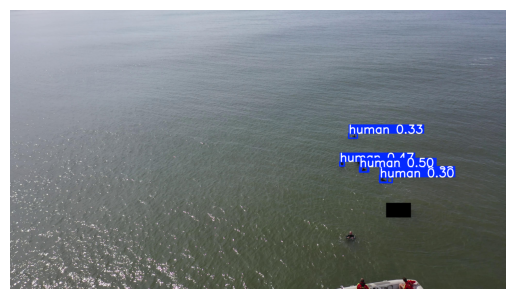

Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 657.11it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.46it/s]


                   all        200       1072      0.677       0.58      0.567      0.213


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.1ms preprocess, 2.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ec4c89a4220>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.0

In [11]:
# model = YOLO("/kaggle/working/yolo11n/weights/best.pt")
model = YOLO("/kaggle/working/ultralytics/runs/detect/yolo11n/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test/10209.jpg"
img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)